# Notes for [Learning scikit-learn : Machine Learning in Python](https://www.amazon.com/Learning-scikit-learn-Machine-Python/dp/1783281936)

## Ch1. Introduction
A simple linear classification exmaple:

In [1]:
# Load Iris dataset
from sklearn import datasets
iris = datasets.load_iris()
X_iris, y_iris = iris.data, iris.target
print X_iris.shape, y_iris.shape
print X_iris[0], y_iris[0]

(150, 4) (150,)
[ 5.1  3.5  1.4  0.2] 0


In [2]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

# Get dataset with only the first two attributes
X, y = X_iris[:, :2], y_iris
# Split the dataset into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
print X_train.shape, y_train.shape
# Gtandardize the features (minus mean divide by STD)
# Calcuate the mean and STD
scaler = preprocessing.StandardScaler().fit(X_train)
print scaler.mean_, scaler.scale_
# Scaling X_train
X_train = scaler.transform(X_train)
# Use the same scaler for X_test
X_test = scaler.transform(X_test)

(112, 2) (112,)
[ 5.78392857  3.05535714] [ 0.86060128  0.47280306]


/Users/yanshi/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


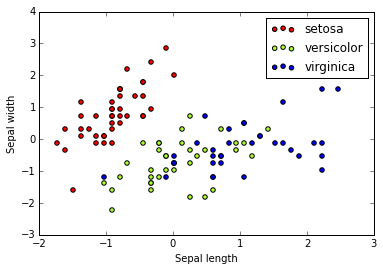

In [3]:
# Let take a look how the training instances are distributed
%matplotlib inline
import matplotlib.pyplot as plt
colors = ['red', 'greenyellow', 'blue']
for i in xrange(len(colors)):
    xs = X_train[:, 0][y_train == i]
    ys = X_train[:, 1][y_train == i]
    plt.scatter(xs, ys, c=colors[i])
plt.legend(iris.target_names)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')


In [4]:
# Use SGDclassifier - Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [5]:
# Print the coefficients for linear speration planes
print clf.coef_
print clf.intercept_

[[-22.59964177  15.06870628]
 [ -2.35579305 -19.59900865]
 [ 11.06024871   0.75101269]]
[-16.34285576  -8.52236038 -11.30373777]


The classifier used the one-versus-all method, so we have three classes. The following code draws the three dicision boundaries and lets us know if they worked as expected.

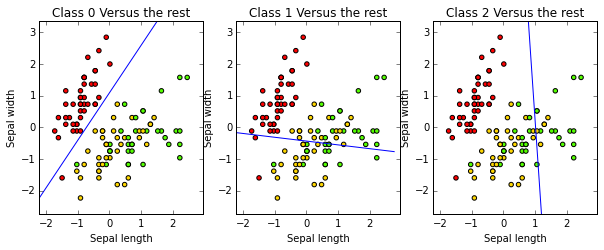

In [6]:
# Draw dicision boundaries
import numpy as np
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xs = np.arange(x_min, x_max, 0.5)
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(10, 6)
for i in [0, 1, 2]:
    axes[i].set_aspect('equal')
    axes[i].set_title('Class ' + str(i) + ' Versus the rest')
    axes[i].set_xlabel('Sepal length')
    axes[i].set_ylabel('Sepal width')
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)
    fig.sca(axes[i])
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.prism)
    ys = (-clf.intercept_[i] - xs * clf.coef_[i, 0]) / clf.coef_[i, 1]
    plt.plot(xs, ys, hold=True)
    

In [7]:
# Predict new data
print clf.predict(scaler.transform([[4.7, 3.1]]))

[0]


In [8]:
# Check scores for each class
print clf.decision_function(scaler.transform([[4.7, 3.1]]))

[[ 13.54423856  -7.40580685 -25.1632253 ]]


In [9]:
# Evaluate our model 
from sklearn import metrics
y_train_pred = clf.predict(X_train)
print metrics.accuracy_score(y_train, y_train_pred)

0.794642857143


* Precision : This computes the proportion of instances predicted as positives that were correctly evaluated (it measures how right our classifier is when it says that an instance is positive). 
* Recall : This counts the proportion of positive instances that were correctly evaluated (measuring how right our classifier is when faced with a positive instance). 
* F1-score : This is the harmonic mean of precision and recall, and tries to combine both in a single number.



* Accuracy = (TP + TN) / (total number of samples)
* Precision = TP / (TP + FP) 
* Recall = TP / (TP + FN) 
* F1-score = 2 \* Precision \* Recall / (Precision + Recall)

In [10]:
# Get the report
y_pred = clf.predict(X_test)
print metrics.classification_report(y_test, y_pred, target_names=iris.target_names)

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00         8
 versicolor       0.50      0.64      0.56        11
  virginica       0.75      0.63      0.69        19

avg / total       0.73      0.71      0.72        38



As we explained before, we have to partition our dataset into  a training set and a testing set. However, partitioning the data, results such that  there are fewer instances to train on, and also, depending on the particular partition we make (usually made randomly), we can get either better or worse results.  

Cross-validation allows us to avoid this particular case, reducing result variance and producing a more realistic score for our models. The usual steps for k-fold  cross-validation are the following: 

* Partition the dataset into k  different subsets. 
* Create k  different models by training on k-1 subsets and testing on the remaining subset. 
* Measure the performance on each of the k  models and take the average measure.

In [11]:
# Cross-validation
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.pipeline import Pipeline

# Create a composite estimator made by a pipeline of the standarization and the linear model
clf = Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('linear_model', SGDClassifier())
    ])
# Create a k-fold cross-validation iterator of k=5 folds
cv = KFold(X.shape[0], 5, shuffle=True, random_state=33)
# By default, score is accuracy
scores = cross_val_score(clf, X, y, cv=cv)
print scores

[ 0.53333333  0.73333333  0.66666667  0.86666667  0.7       ]


In [12]:
# Calcuate the mean score
from scipy.stats import sem

def mean_score(scores):
    return ("Mean score: {0:.3f} (+/- {1:.3f})").format(np.mean(scores), sem(scores))
print mean_score(scores)

Mean score: 0.700 (+/- 0.054)


Curse of dimensionality: when the number of parameters of a model grows, the data needed to learn them grows exponentially.

Other things to pay attention to:

* Tradeoff between bias and variance
* Feature selection and engineering

## Ch2. Supervised Learning

### Support Vector Machine (SVM):

* Very effective for high-dimensional spaces and sparse data
* Calculation intensive

The following is about using SVM to do image recognition.

In [13]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
print faces.DESCR

Modified Olivetti faces dataset.

The original database was available from (now defunct)

    http://www.uk.research.att.com/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



In [14]:
print faces.keys()

['images', 'data', 'target', 'DESCR']


In [15]:
print faces.images.shape
print faces.data.shape
print faces.target.shape

(400, 64, 64)
(400, 4096)
(400,)


In [16]:
# data is already normalized
print np.max(faces.data)
print np.min(faces.data)

1.0
0.0


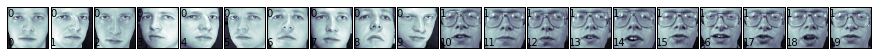

In [17]:
# plot faces
def print_faces(images, target, top_n):
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1,
                       hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        # label the image with the target value
        p.text(0, 14, str(target[i]))
        p.text(0, 60, str(i))

print_faces(faces.images, faces.target, 20)

In [18]:
# Train a SVM
from sklearn.svm import SVC

svc_1 = SVC(kernel='linear')
X_train, X_test, y_train, y_test = train_test_split(faces.data,faces.target,
                                                   test_size=0.25, random_state=0)
def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print scores
    print ("Mean score: {0:.3f} (+/-{1:0.3f})").format(np.mean(scores), sem(scores))
evaluate_cross_validation(svc_1, X_train, y_train, 5)

[ 0.93333333  0.86666667  0.91666667  0.93333333  0.91666667]
Mean score: 0.913 (+/-0.012)


### Naive Bayes

Naïve Bayes  is a simple but powerful classifier based on a probabilistic model derived from the Bayes' theorem. Basically it determines the probability that an instance belongs to a class based on each of the feature value probabilities. **The naïve term comes from the fact that it assumes that each feature is independent of the rest, that is, the value of a feature has no relation to the value of another feature.**

In [19]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups(subset='all')
print type(news.data), type(news.target), type(news.target_names)
print news.target_names

<type 'list'> <type 'numpy.ndarray'> <type 'list'>
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [20]:
print len(news.data)
print len(news.target)

18846
18846


In [21]:
print news.data[0]

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [22]:
print news.target[0], news.target_names[news.target[0]]

10 rec.sport.hockey


In [23]:
# Train test seperation
# Because the loaded data is already in random order, so we split it directly.
SPLIT_PERC = 0.75
split_size = int(len(news.data)*SPLIT_PERC)
X_train = news.data[:split_size]
X_test = news.data[split_size:]
y_train = news.target[:split_size]
y_test = news.target[split_size:]

* `CountVectorizer` basically creates a dictionary of words from the text corpus. Then, each instance is converted to a vector of numeric features where each element will be the count of the number of times a particular word appears in the document.

* `HashingVectorizer` instead of constricting and maintaining the dictionary in memory, implements a hashing function that maps tokens into feature indexes, and then computes the count as in CountVectorizer.

* `TfidVectorizer`, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [25]:
# Build Naive Bayes models
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

clf_1 = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB())
    ])
clf_2 = Pipeline([
        ('vect', HashingVectorizer(non_negative=True)),
        ('clf', MultinomialNB())
    ])
clf_3 = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])
clfs = [clf_1, clf_2, clf_3]
for clf in clfs:
    evaluate_cross_validation(clf, news.data, news.target, 5)

[ 0.85782493  0.85725657  0.84664367  0.85911382  0.8458477 ]
Mean score: 0.853 (+/-0.003)
[ 0.75543767  0.77659857  0.77049615  0.78508888  0.76200584]
Mean score: 0.770 (+/-0.005)
[ 0.84482759  0.85990979  0.84558238  0.85990979  0.84213319]
Mean score: 0.850 (+/-0.004)


In [34]:
# Refine TfidfVectorizer by parsing text into tokens with regular expression
clf_4 = Pipeline([
        ('vect', TfidfVectorizer(token_pattern=ur'\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b')),
        ('clf', MultinomialNB())
    ])
evaluate_cross_validation(clf_4, news.data, news.target, 5)

[ 0.86100796  0.8718493   0.86203237  0.87291059  0.8588485 ]
Mean score: 0.865 (+/-0.003)


In [ ]:
# Use stop_words to get rid of nonimportant words
def get_stop_words():
    result = set()
    for line in open('stopwords_en.txt', 'r').readlines():
        result.add(lien.strip())
    return result
clf_5 = Pipeline([
        ('vect', TfidfVectorizer(stop_words=get_stop_words(),
                                token_pattern=ur'\b[a-z0-9_\-\.]+[a-z][a-z0->>> 9_\-\.]+\b')),
        ('clf', MultinomialNB())
    ])
evaluate_cross_validation(clf_5, news.data, news.target, 5)

In [35]:
# Evaluate the model
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_trian, y_test):
    clf.fit(X_train, y_train)
    print "Accuracy on training set:"
    print clf.score(X_train, y_train)
    print "Accuracy on testing set:"
    print clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    
    print "Classification Report:"
    print metrics.classification_report(y_test, y_pred)
    print "Confusion Matrix:"
    print metrics.confusion_matrix(y_test, y_pred)

train_and_evaluate(clf_4, X_train, X_test, y_train, y_test)

Accuracy on training set:
0.930451393802
Accuracy on testing set:
0.856960950764
Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.66      0.76       216
          1       0.87      0.76      0.81       246
          2       0.90      0.78      0.84       274
          3       0.75      0.86      0.80       235
          4       0.93      0.89      0.91       231
          5       0.88      0.92      0.90       225
          6       0.91      0.70      0.79       248
          7       0.94      0.89      0.92       275
          8       0.95      0.96      0.96       226
          9       0.96      0.96      0.96       250
         10       0.96      1.00      0.98       257
         11       0.82      0.99      0.89       261
         12       0.83      0.90      0.86       216
         13       0.96      0.90      0.93       257
         14       0.93      0.95      0.94       246
         15       0.53      0.98      0.69     

In [36]:
# Look inside of the vectorizer
print len(clf_4.named_steps['vect'].get_feature_names())

146051


### Decision Trees

`LabelEncoder` in sklearn can convert categorical sets into integers.

Information Gain(IG) measures how much entropy we lose, or how much surer we are afer answering the quesiton. Entropy is a measure of disorder in a set, if we have zero entropy, it means all values are the same, while it reaches its maximum when there is an equal number of instances of each class. At each node, we have a certain number of instances, and we measure its entropy. The model will select the questions that yield more homogeneous partitions (with the lowest entropy).

In [ ]:
# Use decision trees to classifify Titanic survivors
from sklearn.cross_validation import train_test_split
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)
clf = tree.DecisionTreeClassifier(criterion='entropy', 
                                 max_depth=3, min_samples_leaf=5)
clf = clf.fit(X_train, y_train)

In [ ]:
# Set the tree results
import pydot, StringIO
dot_data = StringIO.StringIO()
tree.export_graphviz(clf, out_file=dot_data, 
                    feature_names=['age', 'sex', 'class'])
graph = pydot.graph_from_dot_data(dot_data.getvalue())

### Random Forests

Random Forests try to introduce some level of randomization in each step, proposing alternative trees and combining them to get the final prediction, which is an ensemble methods. 

Random forest uses the fully grown trees (low bias, high variance), and it tackles the error reduction task by reducing variance. The boosting trees are based on weak learners (high bias, low variance), such as shallow trees, and boosting reduces errors by reducing bias.

### Regression 

In [39]:
# Prediciton house price
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

boston = load_boston()
print boston.data.shape
print boston.feature_names
print np.max(boston.target), np.min(boston.target)

(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
50.0 5.0


In [42]:
# Build the model
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(boston.data,
                                                   boston.target,
                                                   test_size=0.25,
                                                   random_state=33)
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

def train_and_evaluate(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    print "Coefficient of determination on training set:", clf.score(X_train, y_train)
    # create a k-fold cross validation iterator of k=5 folds
    cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    print "Average coefficient of determination using 5-fold crossvalidation:", np.mean(scores)
    
# a linear model
from sklearn import linear_model
clf_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None, random_state=42)
train_and_evaluate(clf_sgd, X_train, y_train)
print clf_sgd.coef_

Coefficient of determination on training set: 0.743617732983
Average coefficient of determination using 5-fold crossvalidation: 0.710809853468
[-0.08527595  0.06706144 -0.05032898  0.10874804 -0.07755151  0.38961893
 -0.02485839 -0.20990016  0.08491659 -0.05495108 -0.19854006  0.06126093
 -0.37817963]


/Users/yanshi/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yanshi/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yanshi/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

In [44]:
# Use penatly term to avoid overfitting
clf_sgd1 = linear_model.SGDRegressor(loss='squared_loss', penalty="l2", random_state=42)
train_and_evaluate(clf_sgd1, X_train, y_train)

Coefficient of determination on training set: 0.743616743208
Average coefficient of determination using 5-fold crossvalidation: 0.71081206667


In [45]:
# SVM for regression
from sklearn import svm
clf_svr = svm.SVR(kernel='linear')
train_and_evaluate(clf_svr, X_train, y_train)

Coefficient of determination on training set: 0.71886923342
Average coefficient of determination using 5-fold crossvalidation: 0.707838419194


In [47]:
# Random Forests for regression
from sklearn import ensemble
clf_et = ensemble.ExtraTreesRegressor(n_estimators=10, random_state=42)
train_and_evaluate(clf_et, X_train, y_train)

Coefficient of determination on training set: 1.0
Average coefficient of determination using 5-fold crossvalidation: 0.861758978344


In [49]:
print np.sort(zip(clf_et.feature_importances_, boston.feature_names), axis=0)

[['0.00504385320276' 'AGE']
 ['0.0151425137151' 'B']
 ['0.0170525784005' 'CHAS']
 ['0.0189418210858' 'CRIM']
 ['0.0236025617776' 'DIS']
 ['0.0257330490046' 'INDUS']
 ['0.0318741622351' 'LSTAT']
 ['0.0344056449393' 'NOX']
 ['0.0397131333452' 'PTRATIO']
 ['0.0466185213973' 'RAD']
 ['0.0995118014928' 'RM']
 ['0.284215227964' 'TAX']
 ['0.35814513144' 'ZN']]


In [50]:
# Evaluate model performance
from sklearn import metrics
def measure_performance(X, y, clf, show_accuracy=True, 
                        show_classification_report=True,
                        show_confusion_matrix=True,
                        show_r2_score=False):
    y_pred = clf.predict(X)
    if show_accuracy:
        print "Accuracy:{0: .3f}".format(metrics.accuracy_score(y, y_pred)), "\n"
    if show_classification_report:
        print "Classification Report:"
        print metrics.classificaiton_report(y, y_pred), "\n"
    if show_confusion_matrix:
        print "Confusion_matrix"
        print metrics.confusion_matrix(y, y_pred), "\n"
    if show_r2_score:
        print "Coefficient of determination:{0: 0.3f}".format(metrics.r2_score(y, y_pred)), "\n"
        
measure_performance(X_test, y_test, clf_et, 
                   show_accuracy=False,
                   show_classification_report=False,
                   show_confusion_matrix=False,
                   show_r2_score=True)

Coefficient of determination: 0.802 



## Ch3. Unsupervised Learning

Clustering invovles finding groups where all elements in the group are similar, but objects in different groups are not.

### Principal Component Analysis (PCA)

PAC is an orthogonal linear transformation that turns a set of possible correlated variables into a new set of variables that are as uncorrelated as possible. 

PCA will allow us to reduce a high-dimensional space into a low-dimensional one while preserving as much variance as possible, which is useful for **visulizaiton** and **feature selection**.

In [54]:
# Hand-written images reduction
from sklearn.datasets import load_digits
digits = load_digits()
X_digits, y_digits = digits.data, digits.target
print digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']


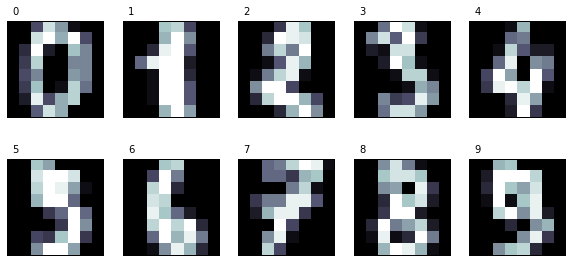

In [55]:
# Print digits
n_row, n_col = 2, 5

def print_digits(images, y, max_n=10):
    # set up the figrue size in inches
    fig = plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    i = 0
    while i < max_n and i < images.shape[0]:
        p = fig.add_subplot(n_row, n_col, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone, interpolation='nearest')
        # label the image with the target value
        p.text(0, -1, str(y[i]))
        i = i + 1
print_digits(digits.images, digits.target, max_n=10)

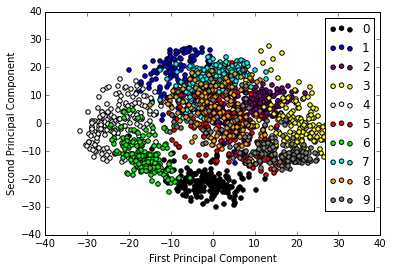

In [57]:
# plot PCA results 
def plot_pca_scatter():
    colors = ['black', 'blue', 'purple', 'yellow', 'white',
             'red', 'lime', 'cyan', 'orange', 'gray']
    for i in xrange(len(colors)):
        px = X_pca[:, 0][y_digits == i]
        py = X_pca[:, 1][y_digits == i]
        plt.scatter(px, py, c=colors[i])
    plt.legend(digits.target_names)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
from sklearn.decomposition import PCA
estimator = PCA(n_components=10)
X_pca = estimator.fit_transform(X_digits)
plot_pca_scatter()

### K-means

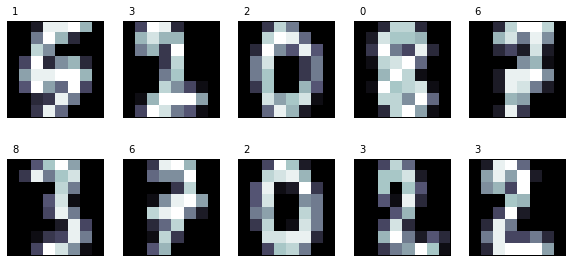

In [62]:
from sklearn.preprocessing import scale
from sklearn import cluster

data = scale(digits.data)
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(data,
                                                                              digits.target,
                                                                              digits.images,
                                                                              test_size=0.25,
                                                                              random_state=42)
n_samples, n_features = X_train.shape
n_digits = len(np.unique(y_train))
labels = y_train
clf = cluster.KMeans(init='k-means++', n_clusters=10, random_state=42)
clf.fit(X_train)
print_digits(images_train, clf.labels_, max_n=10)

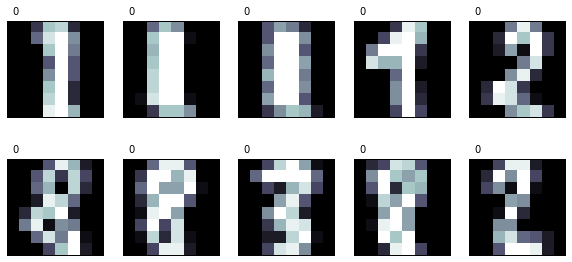

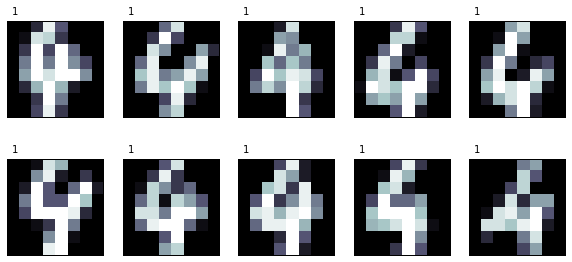

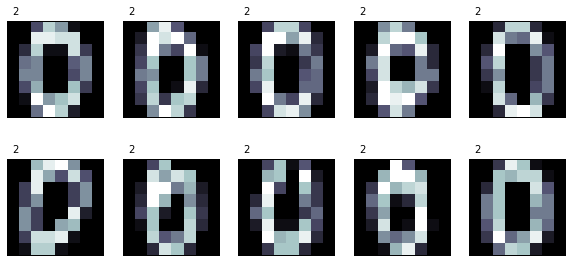

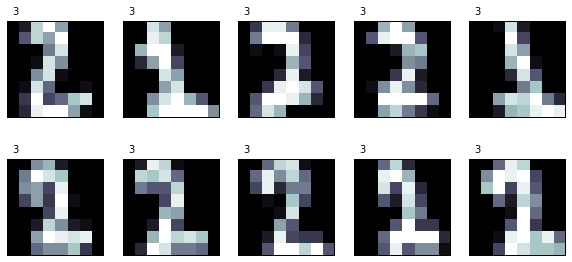

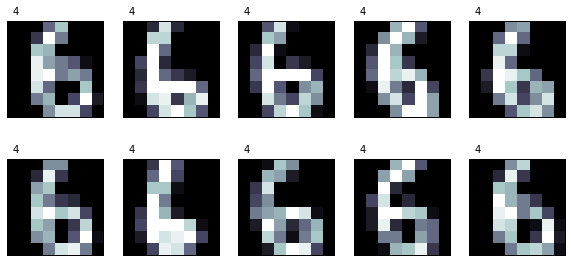

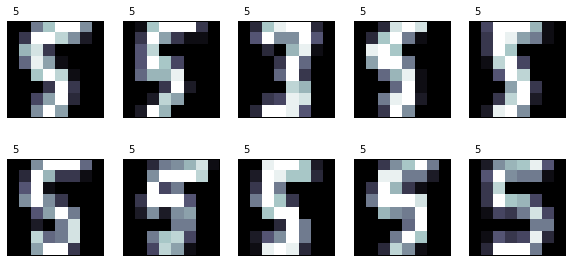

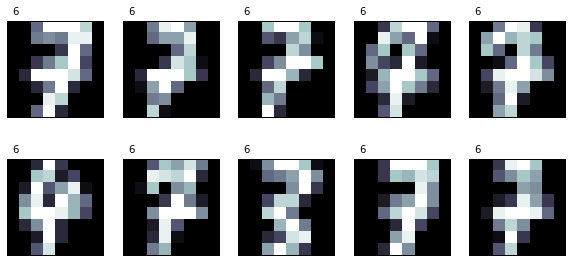

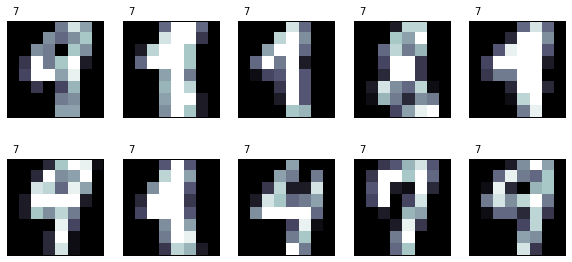

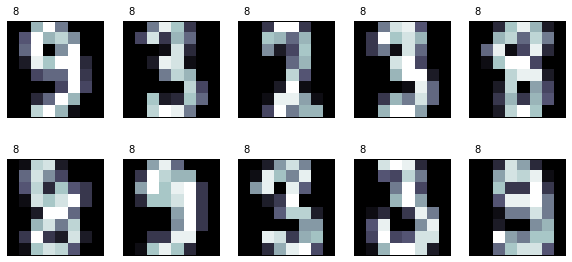

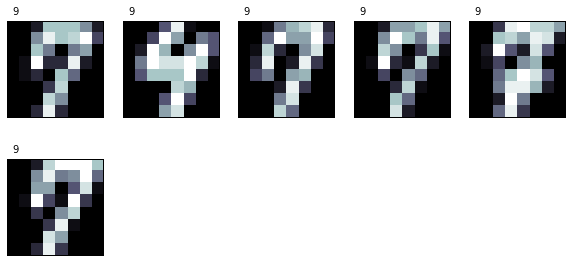

In [63]:
y_pred = clf.predict(X_test)

def print_cluster(images, y_pred, cluster_number):
    images = images[y_pred==cluster_number]
    y_pred = y_pred[y_pred==cluster_number]
    print_digits(images, y_pred, max_n=10)
for i in range(10):
    print_cluster(images_test, y_pred, i)

The [Rand Index](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [64]:
# Evaluate the model
from sklearn import metrics
print "Adjusted rand score: {:.2}".format(metrics.adjusted_rand_score(y_test, y_pred))

Adjusted rand score: 0.57


Gaussian Mixture Models (GMM) assume that data comes from a mixture of finite Gaussian distributions with unknown parameters. 

In [65]:
from sklearn import mixture
gm = mixture.GMM(n_components=n_digits, covariance_type='tied', random_state=42)
gm.fit(X_train)

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=1, n_iter=100, params='wmc', random_state=42,
  thresh=None, tol=0.001, verbose=0)

In [66]:
y_pred = gm.predict(X_test)
print "Adjsuted rand score: {:.2}".format(metrics.adjusted_rand_score(y_test, y_pred))
print "Homogeneity score:{:.2}".format(metrics.homogeneity_score(y_test, y_pred))
print "Completeness score:{:.2}".format(metrics.completeness_score(y_test, y_pred))

Adjsuted rand score: 0.65
Homogeneity score:0.75
Completeness score:0.8


Homogeneity is a number between 0.0 and 1.0 (greater is better). Completeness is statisfied when every data point of a given class is within the same cluster.

## Ch4. Advanced Features

* Feature extraction
* Feature selection
* Model selection  

The general approach in feature selection is to get some kind of evaluation function that when given a potential featrue, returns a score of how useful the feature is, and then keeps the features with highest scores. 

Sklearn provides several methods in the `feature_selection` module. Given a statistical test, `SelectPercentile` method selects a user-specificed percentile of features with the highest scoring. The most popular statistical test is the chi-squared statistic. 

In [ ]:
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)
df.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_f)

With `GridSearchCV`, we can specify a grid of any number of parameters and parameter values to traverse. It will train the classifier for each combination and obtain a cross-validation accuracy to evaluate each one. 

In [ ]:
from sklearn.grid_search import GridSearchCV

parameters = {'svc__gamma': np.logspace(-2, 1, 4),
             'svc__C': np.logspace(-1, 1, 3)
             }
clf = Pipeline([
        ('vect', TfidfVectorizer(stop_words=stopd_words)),
        ('svc', SVC())
    ])
gs = GridSearchCV(clf, parameters, verbose=2, refit=False, cv=3)
print gs.best_params_, gs.beat_score_

In [ ]:
# Use parallel GridSearchCV
from sklearn.externals import joblib
from sklearn.cross_validation import ShuffleSplit
import os

# persiste all K folds for cross validation in different files
def persist_cv_splits(X, y, K=3, name='data', suffix='_cv_%03d.pkl'):
    cv_split_filenames = []
    # create KFold cross validation
    cv = KFold(n_samples, K, shuffle=True, random_state=0)
    # Iterate over the K folds
    for i, (train, test) in enumerate(cv):
        cv_fold = ([X[k] for k in train], y[train], [X[k] for k in test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    return cv_split_filenames
cv_filenames = persist_cv_splits(X, y, names='news')

# Load a particular fold and fit the classifer with the specified parameter set
def compute_evaluation(cv_split_filename, clf, params):
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib
    # Load the fold training and testing partitions from the file system
    X_train, y_train, X_test, y_test = joblib.load(cv_split_filename, mmap_mode='c')
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return test_score

# Execute grid search

from sklearn.grid_search import IterGrid

def parallel_grid_search(lb_view, clf, cv_split_filenames, param_grid):
    all_tasks = []
    all_parameters = list(IterGrid(param_grid))
    # Iterate over parameter combinations
    for i, params in enumerate(all_parameters):
        task_for_params = []
        # Iterate over the K folds
        for j, cv_split_filename in enumerate(cv_split_filenames):
            t = lb_view.apply(compute_evaluation, cv_split_filename, clf, params)
            task_for_params.append(t)
        all_tasks.append(task_for_params)
    return all_parameters, all_tasks

# Load N engines
from sklearn.svm import SVC
from IPython.parallel import Client

client = Client()
lb_view = client.load_balanced_view()
all_parameters, all_tasks = parallel_grid_search(lb_view, clf, cv_filenames, parameters)
def print_progress(tasks):
    progess = np.mean([task.ready() for task_group in tasks for task in task_group])
    print "Task completed: {0}%".format(100 * progess)
